In [38]:
import pandas as pd
from sklearn.cluster import KMeans, SpectralClustering
import matplotlib.pyplot as plt
from matplotlib.image import imread
import pandas as pd
import seaborn as sns
from sklearn.metrics import silhouette_samples, silhouette_score

In [39]:
df=pd.read_csv('norm.csv')

In [52]:
df_req = df[['Stride Length (m)', 'Cadence(steps/min)', 'Leg Length (m)',
       'Age(years)','classs']]
x  = df_req[['Stride Length (m)', 'Cadence(steps/min)', 'Leg Length (m)',
       'Age(years)']]
labels = df.classs.values

In [43]:
from sklearn.model_selection import train_test_split
x_tr,x_tt,y_tr,y_tt = train_test_split(X,labels,test_size=.30)

In [46]:
import numpy as np
from scipy.linalg import norm
from scipy.spatial.distance import cdist

class FCM:
    """ Fuzzy C-means
    
    m: float, optional (default=2.0)
        Exponent for the fuzzy partition matrix, specified as a
        scalar greater than 1.0. This option controls the amount of
        fuzzy overlap between clusters, with larger values indicating
        a greater degree of overlap.
    
    u: array, shape = [n_samples, n_clusters]
        Fuzzy partition array, returned as an array with n_samples rows
        and n_clusters columns. Element u[i,j] indicates the degree of
        membership of the jth data point in the ith cluster. For a given
        data point, the sum of the membership values for all clusters is one.
    """
    def __init__(self, n_clusters=3, max_iter=1500, m=2, error=1e+5, random_state=42):
        assert m > 1
        self.u, self.centers = None, None
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.m = m
        self.error = error
        self.random_state = random_state

    def fit(self, X):
        self.n_samples = X.shape[0]
        r = np.random.RandomState(self.random_state)
        self.u = r.rand(self.n_samples,self.n_clusters)
        self.u = self.u / np.tile(self.u.sum(axis=1)[np.newaxis].T, self.n_clusters)
        er_old = self.error
        for iteration in range(self.max_iter):
            distance = np.zeros(X.shape[0])
            for k in range(self.n_clusters):
                self.centers = self.next_centers(X)
                self.u = self._predict(X)
                labels = self.predict(X)
                distance[labels == k] = norm(X[labels == k] - self.centers[k], axis=1)
                distance = np.square(distance)
                u = self.u**2
                error = np.expand_dims(distance, axis=0) @ u
                error = np.mean(error)
                if error < er_old:
                    break
                else:
                    er_old = error 
                    
    def next_centers(self, X):
        um = self.u ** self.m
        return (X.T @ um / np.sum(um, axis=0)).T

    def _predict(self, X):
        power = float(2 / (self.m - 1))
        temp = cdist(X, self.centers) ** power
        denominator_ = temp.reshape((X.shape[0], 1, -1)).repeat(temp.shape[-1], axis=1)
        denominator_ = temp[:, :, np.newaxis] / denominator_
        return 1 / denominator_.sum(2)

    def predict(self, X):
        if len(X.shape) == 1:
            X = np.expand_dims(X, axis=0)
        u = self._predict(X)
        return np.argmax(u, axis=-1)

In [56]:
a = FCM(n_clusters = 2)

In [57]:
b = a.fit(x.values)

In [58]:
print("Silhouette Coefficient: %0.3f"
      % silhouette_score(x.values,labels, metric='euclidean'))

Silhouette Coefficient: 0.082


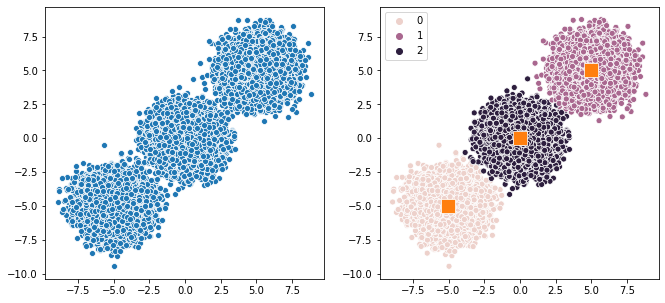

In [47]:
from sklearn.datasets import make_blobs
from matplotlib import pyplot as plt
from seaborn import scatterplot as scatter

n_samples = 50000
n_bins = 3  
centers = [(-5, -5), (0, 0), (5, 5)]

X,_ = make_blobs(n_samples=n_samples, n_features=2, cluster_std=1.0,
                  centers=centers, shuffle=False, random_state=42)

fcm = FCM(n_clusters=3)
fcm.fit(X)

fcm_centers = fcm.centers
fcm_labels  = fcm.u.argmax(axis=1)

%matplotlib inline
f, axes = plt.subplots(1, 2, figsize=(11,5))
scatter(X[:,0], X[:,1], ax=axes[0])
scatter(X[:,0], X[:,1], ax=axes[1], hue=fcm_labels)
scatter(fcm_centers[:,0], fcm_centers[:,1], ax=axes[1],marker="s",s=200)
plt.show()